In [1]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
# usefull fucntions
def remove_nan_values(sample_array:np.array) -> np.array:
    for sample_index, i in enumerate(sample_array):
        for value_index, j in enumerate(i):
            if j==' ':
               sample_array[sample_index][value_index] = 0.0
            elif type(j) == str:
                sample_array[sample_index][value_index] = int(j)
            elif np.isnan(j):
               sample_array[sample_index][value_index] = 0.0
    return sample_array

def remove_1d_array_nan_values(sample_array: np.array, attack_categories: dict) -> np.array:
    for value_index, j in enumerate(sample_array):
        if j==' ':
           sample_array[value_index] = 0.0
        elif type(j) == str:
            try:
                sample_array[value_index] = int(j)
            except:
                sample_array[value_index] = attack_categories[j]
        elif np.isnan(j):
           sample_array[value_index] = 0.0
    return sample_array

def save_model(model, name, prefix) -> None:
    """Function responsible for saving trained model. It must be called
    after defining, training and predict.

    :param: None
    :return: None
    """

    filename = f"{name}_{prefix}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filepath):
    """Function responsible for load model.

    :param: None
    :return: None
    """
    return pickle.load(open(filepath, 'rb'))

### Load data

In [3]:
dataset_testing_path = '../../Datasets/UNSW-NB15/UNSW-NB15 - CSV Files/Splitted_Dataset/UNSW_NB15_testing-set.csv'
dataset_traning_path = '../../Datasets/UNSW-NB15/UNSW-NB15 - CSV Files/Splitted_Dataset/UNSW_NB15_training-set.csv'
dataset_features_path = '../../Datasets/UNSW-NB15/UNSW-NB15 - CSV Files/NUSW-NB15_features.csv'


features_columns = pd.read_csv(dataset_features_path, sep=",", encoding='cp1252')
features_list = list(features_columns['Name'])

In [4]:
# load data to pandas DataFrame
df_training = pd.read_csv(dataset_traning_path, index_col=None, header=0)
df_training = df_training.drop(df_training.columns[0], axis=1)

df_testing = pd.read_csv(dataset_testing_path, index_col=None, header=0)
df_testing = df_testing.drop(df_testing.columns[0], axis=1)

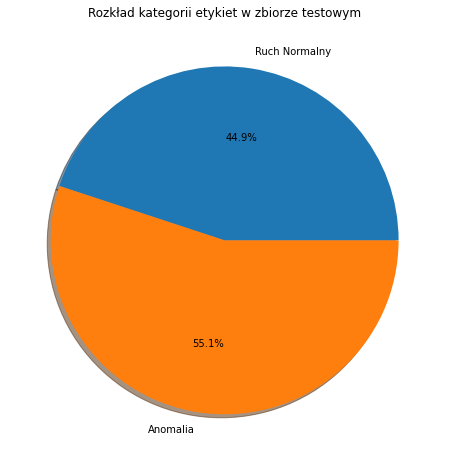

In [5]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii etykiet w zbiorze testowym")
plt.pie([df_testing[df_testing['label'] == 0].shape[0], df_testing[df_testing['label'] == 1].shape[0]],
       labels=['Ruch Normalny', 'Anomalia'], autopct='%1.1f%%', shadow=True)
plt.show()

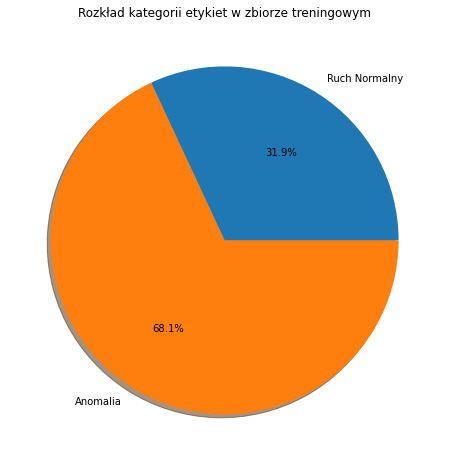

In [6]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii etykiet w zbiorze treningowym")
plt.pie([df_training[df_training['label'] == 0].shape[0], df_training[df_training['label'] == 1].shape[0]],
       labels=['Ruch Normalny', 'Anomalia'], autopct='%1.1f%%', shadow=True)
plt.show()

## Inspect Data

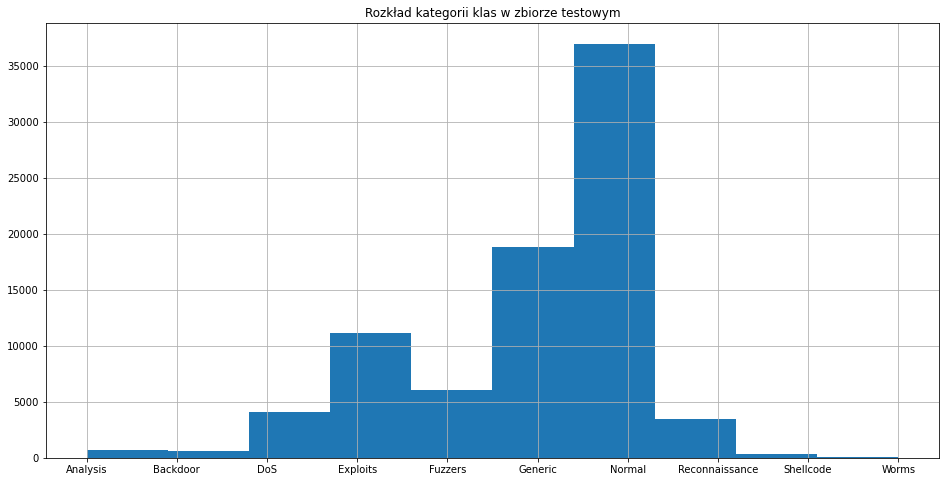

In [56]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii klas w zbiorze testowym")
plt.hist(df_testing['attack_cat'].sort_values())
plt.show()

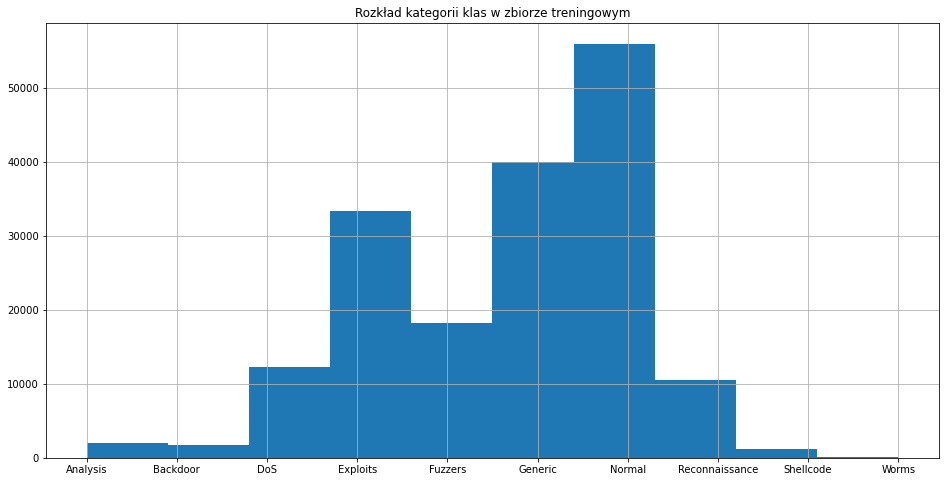

In [55]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii klas w zbiorze treningowym")
plt.hist(df_training['attack_cat'].sort_values())
plt.show()

In [7]:
# features list
features_list = list(df_training.columns)
features_list.remove('attack_cat')
features_list.remove('label')


# categorical values
categorical_features = ['state', 'proto', 'service']

for categorical_feature in categorical_features:
    test_list = list(df_testing[features_list][categorical_feature].unique())

    label_encoding = {name: index for index, name in enumerate(list(df_training[features_list][categorical_feature].unique()))}
    for i in test_list:
        if i not in label_encoding.keys():
            label_encoding[i] = max(label_encoding.values()) + 1
    
    
    for name, value in label_encoding.items():
        df_training[features_list]= df_training[features_list].replace(name, value)
        df_testing[features_list]= df_testing[features_list].replace(name, value)

### Binary classification

In [8]:
# prepare data for classification
x_train = df_training[features_list].to_numpy()
y_train = df_training['label'].to_numpy()

x_test = df_testing[features_list].to_numpy()
y_test = df_testing['label'].to_numpy()

# remove nan values
x_train = remove_nan_values(x_train)
x_test = remove_nan_values(x_test)

# normalization min max
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### Define models

In [8]:
models = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]

models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [13]:
# train models
for model in models_mlp:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


In [11]:
# train models
for model in models_mlp_downsampling:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [25]:
# train models
for model in models_mlp3:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(200, 200, 200), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(300, 150, 75), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


In [19]:
# train models
for model in models_mlp2:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


In [26]:
predictions3 = {i: None for i in models_mlp3}
for model, model_str in zip(models_mlp3, predictions3):
    predictions3[model_str] = model.predict(x_test)

In [12]:
predictions3 = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions3):
    predictions3[model_str] = model.predict(x_test)

In [17]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4


results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",83.2,77.0,99.1,86.7
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",84.8,79.5,97.5,87.6
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",84.2,78.9,97.4,87.2
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",84.2,78.6,98.0,87.2


In [23]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp2, predictions2):
    accuracy = accuracy_score(y_test, predictions2[model_str])
    precision = precision_score(y_test, predictions2[model_str], average='binary')
    recall = recall_score(y_test, predictions2[model_str], average='binary')
    f1_ = f1_score(y_test, predictions2[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4


results = {'Model': models_mlp2,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",84.0,78.6,97.5,87.0
1,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",85.0,79.7,97.6,87.7
2,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",83.4,77.4,98.6,86.7


In [27]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp3, predictions3):
    accuracy = accuracy_score(y_test, predictions3[model_str])
    precision = precision_score(y_test, predictions3[model_str], average='binary')
    recall = recall_score(y_test, predictions3[model_str], average='binary')
    f1_ = f1_score(y_test, predictions3[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4


results = {'Model': models_mlp3,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",83.0,77.5,97.5,86.3
1,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",84.3,79.0,97.4,87.2
2,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",83.5,78.4,96.7,86.6


In [13]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp_downsampling, predictions3):
    accuracy = accuracy_score(y_test, predictions3[model_str])
    precision = precision_score(y_test, predictions3[model_str], average='binary')
    recall = recall_score(y_test, predictions3[model_str], average='binary')
    f1_ = f1_score(y_test, predictions3[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4


results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",87.1,81.7,98.6,89.4
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",83.9,78.5,97.4,86.9
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",83.7,78.2,97.6,86.8
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",83.7,77.4,99.4,87.0
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",82.5,76.4,98.8,86.1
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",84.4,78.5,98.9,87.5
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",85.1,79.4,98.5,87.9
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",83.6,77.7,98.6,86.9
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",83.3,77.1,99.1,86.7


In [58]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

accuracy_list.append(86.6)
accuracy_list.append(86.6)
precision_list.append(81.3)
recall_list.append(98.5)
f1_list.append(89.1)
precision_list.append(78.2)
recall_list.append(99.2)
f1_list.append(87.5)

results = {'Model': ['NaiveBayes', 'DecisionTree', 'RandomForest', 'MultiLayerPercepton', 'AdaBoost', 'GradientBoost', 'LSTM', 'GRU'],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,NaiveBayes,76.4,77.8,80.0,78.9
1,DecisionTree,88.8,84.3,97.9,90.6
2,RandomForest,90.6,87.5,96.6,91.8
3,MultiLayerPercepton,83.3,77.2,98.7,86.7
4,AdaBoost,85.1,80.0,97.4,87.8
5,GradientBoost,83.0,76.8,98.9,86.5
6,LSTM,86.6,81.3,98.5,89.1
7,GRU,86.6,78.2,99.2,87.5


## Reduced 20 Features

In [10]:
chosen_features = ['sttl', 'ct_state_ttl', 'sload', 'rate', 'dload', 'dttl', 'sbytes', 'ct_srv_dst', 'smean', 
                  'dmean', 'dbytes', 'ackdat', 'ct_dst_src_ltm', 'ct_srv_src', 'dur', 'tcprtt', 'synack',
                  'dinpkt', 'sinpkt', 'dpkts']


### Binary classification

In [11]:
# prepare data for classification
x_train_reduced_bin = df_training[features_list][chosen_features].to_numpy()
y_train_reduced_bin = df_training['label'].to_numpy()

x_test_reduced_bin = df_testing[features_list][chosen_features].to_numpy()
y_test_reduced_bin = df_testing['label'].to_numpy()

# remove nan values
x_train_reduced_bin = remove_nan_values(x_train_reduced_bin)
x_test_reduced_bin = remove_nan_values(x_test_reduced_bin)

# normalization min max
scaler = MinMaxScaler()
x_train_reduced_bin = scaler.fit_transform(x_train_reduced_bin)
x_test_reduced_bin = scaler.fit_transform(x_test_reduced_bin)

In [13]:
models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

models_reduced_bin = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)
                     ]

models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [14]:
# train models
for model in models_mlp_downsampling:
    model.fit(x_train_reduced_bin, y_train_reduced_bin)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [16]:
# train models
for model in models_mlp:
    model.fit(x_train_reduced_bin, y_train_reduced_bin)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0

In [17]:
predictions = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions):
    predictions[model_str] = model.predict(x_test_reduced_bin)

In [19]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_mlp, predictions):
    accuracy = accuracy_score(y_test_reduced_bin, predictions[model_str])
    precision = precision_score(y_test_reduced_bin, predictions[model_str], average='weighted')
    recall = recall_score(y_test_reduced_bin, predictions[model_str], average='weighted')
    f1_ = f1_score(y_test_reduced_bin, predictions[model_str], average='weighted')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",82.1,83.1,82.1,81.7
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",83.6,85.3,83.6,83.1
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",82.2,82.7,82.2,81.9
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",84.3,86.5,84.3,83.8
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",80.8,81.1,80.8,80.6
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",78.3,78.5,78.3,78.1
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",80.5,81.2,80.5,80.1
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",77.8,77.8,77.8,77.7
8,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",80.5,80.8,80.5,80.2
9,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",80.0,80.7,80.0,79.6


In [30]:
# train models
for model in models_reduced_bin:
    model.fit(x_train_reduced_bin, y_train_reduced_bin)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

In [19]:
models_mlp_downsampling
# train models
for model in models_mlp_downsampling:
    model.fit(x_train_reduced_bin, y_train_reduced_bin)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [31]:
save_model(models_reduced_bin[0], 'NaiveBayes', 'REDUCED_BIN')
save_model(models_reduced_bin[1], 'DT', 'REDUCED_BIN')
save_model(models_reduced_bin[2], 'RF', 'REDUCED_BIN')
save_model(models_reduced_bin[3], 'MLP', 'REDUCED_BIN')
save_model(models_reduced_bin[4], 'AdaBoost', 'REDUCED_BIN')
save_model(models_reduced_bin[5], 'GBT', 'REDUCED_BIN')

In [15]:
predictions_reduced_bin = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions_reduced_bin):
    predictions_reduced_bin[model_str] = model.predict(x_test_reduced_bin)

In [32]:
predictions_reduced_bin = {i: None for i in models_reduced_bin}
for model, model_str in zip(models_reduced_bin, predictions_reduced_bin):
    predictions_reduced_bin[model_str] = model.predict(x_test_reduced_bin)

In [16]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_mlp_downsampling, predictions_reduced_bin):
    accuracy = accuracy_score(y_test_reduced_bin, predictions_reduced_bin[model_str])
    precision = precision_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
    recall = recall_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
    f1_ = f1_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
#     fpr_score = det_curve(y_test_multi, predictions_multi[model_str])
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",83.4,77.3,98.8,86.7
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",82.4,77.3,96.5,85.8
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",80.8,77.5,91.9,84.1
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",83.9,77.9,99.0,87.2
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",83.5,77.4,99.0,86.9
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",82.3,77.1,96.5,85.7
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",85.6,79.6,99.2,88.4
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",87.2,82.5,97.3,89.3
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",79.9,74.8,95.5,83.9


In [33]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_reduced_bin, predictions_reduced_bin):
    accuracy = accuracy_score(y_test_reduced_bin, predictions_reduced_bin[model_str])
    precision = precision_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
    recall = recall_score(y_test_reduced_bGBin, predictions_reduced_bin[model_str], average='binary')
    f1_ = f1_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
#     fpr_score = det_curve(y_test_multi, predictions_multi[model_str])
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': ['NaiveBayes', 'DecisionTree', 'RandomForest', 'MultiLayerPercepton', 'AdaBoost', 'GradientBoost'],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,NaiveBayes,74.9,72.4,88.0,79.4
1,DecisionTree,87.9,83.4,97.4,89.9
2,RandomForest,89.9,86.4,96.9,91.3
3,MultiLayerPercepton,84.6,82.1,92.2,86.8
4,AdaBoost,85.6,80.9,96.7,88.1
5,GradientBoost,83.5,77.6,98.4,86.8


In [ ]:
# LSTM REDUCED 
# ACC 88.8 
# PRECISION 72.3
# RECALL 99.6
# F1 83.8

# GRU REDUCED
# ACC 0.8236165767866687 
#PRECISION
#0.7587683934690587 
#RECALL 0.9964484249536751 
#F1 0.8615158681721086

### Reducing features

In [18]:
chosen_features = ['sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
                  'sload', 'dload']


In [19]:
# prepare data for classification
x_train_reduced_bin = df_training[features_list][chosen_features].to_numpy()
y_train_reduced_bin = df_training['label'].to_numpy()

x_test_reduced_bin = df_testing[features_list][chosen_features].to_numpy()
y_test_reduced_bin = df_testing['label'].to_numpy()

# remove nan values
x_train_reduced_bin = remove_nan_values(x_train_reduced_bin)
x_test_reduced_bin = remove_nan_values(x_test_reduced_bin)

# normalization min max
scaler = MinMaxScaler()
x_train_reduced_bin = scaler.fit_transform(x_train_reduced_bin)
x_test_reduced_bin = scaler.fit_transform(x_test_reduced_bin)

In [20]:
models = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)
         ]


In [21]:
# train models
for model in models:
    model.fit(x_train_reduced_bin, y_train_reduced_bin)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

/home/mkubita/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning:

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.



GradientBoostingClassifier(learning_rate=0.05, loss='deviance',
                           n_estimators=3200)


In [22]:
predictions_reduced_bin = {i: None for i in models}
for model, model_str in zip(models, predictions_reduced_bin):
    predictions_reduced_bin[model_str] = model.predict(x_test_reduced_bin)

In [24]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models, predictions_reduced_bin):
    accuracy = accuracy_score(y_test_reduced_bin, predictions_reduced_bin[model_str])
    precision = precision_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
    recall = recall_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
    f1_ = f1_score(y_test_reduced_bin, predictions_reduced_bin[model_str], average='binary')
#     fpr_score = det_curve(y_test_multi, predictions_multi[model_str])
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,GaussianNB(),74.8,72.4,87.6,79.3
1,DecisionTreeClassifier(class_weight='balanced'...,85.7,81.3,96.1,88.1
2,"(DecisionTreeClassifier(criterion='entropy', m...",84.1,80.8,93.3,86.6
3,"MLPClassifier(hidden_layer_sizes=(15, 30, 60),...",79.4,73.0,99.5,84.2
4,(DecisionTreeClassifier(class_weight='balanced...,85.5,81.2,95.9,88.0
5,([DecisionTreeRegressor(criterion='friedman_ms...,82.1,76.3,98.0,85.8


### Feature Importance

In [120]:
# feature importance
importances_list = []
for model in models_reduced_bin:
    features = np.array(chosen_features)
    importances = permutation_importance(model, x_test_reduced_bin, y_test_reduced_bin).importances_mean
    importances_list.append(importances)

feature_importance = {'Features': chosen_features,
           'Importances_NB': importances_list[0],
           'Importances_DT': importances_list[1],
           'Importances_RF': importances_list[2],
           'Importances_MLP': importances_list[3]
            }
 
# Convert the dictionary into DataFrame 
feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df

,Features,Importances_NB,Importances_DT,Importances_RF,Importances_MLP
0,sttl,0.015583,0.199344,0.011631,0.103070
1,ct_state_ttl,0.006156,0.011063,0.009282,0.155033
2,sload,-0.001603,0.000102,0.020082,0.007387
3,rate,0.000491,0.002101,0.013868,0.004579
4,dload,0.036620,0.000000,0.019698,0.006819
5,dttl,-0.002658,0.000000,-0.006139,0.149898
6,sbytes,0.000926,0.144255,0.033316,-0.000163
7,ct_srv_dst,0.003913,0.012748,0.013463,0.006289
8,smean,0.000126,0.038439,0.026524,0.057108
9,dmean,-0.001931,0.023818,0.022519,0.021928


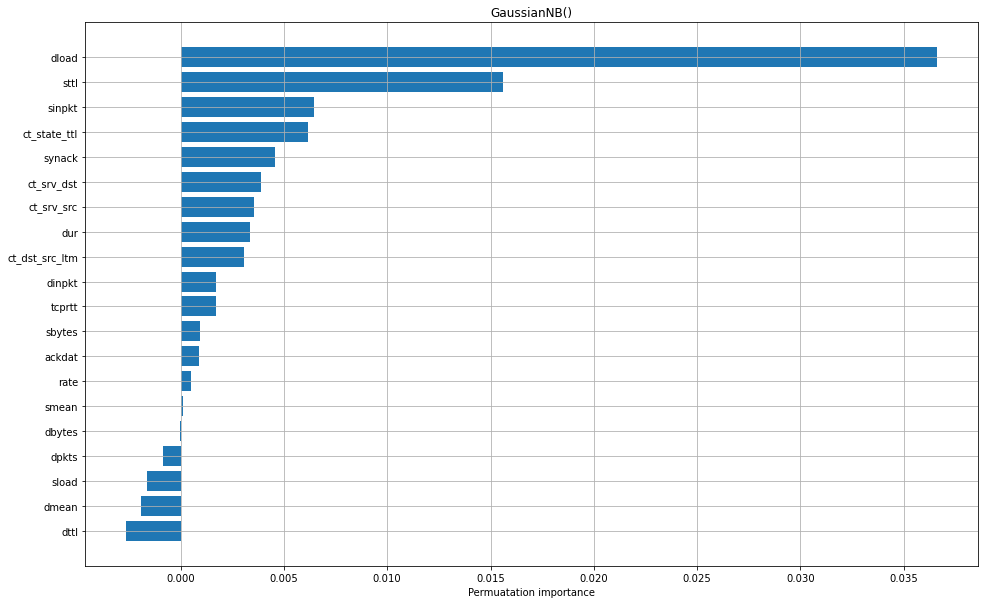

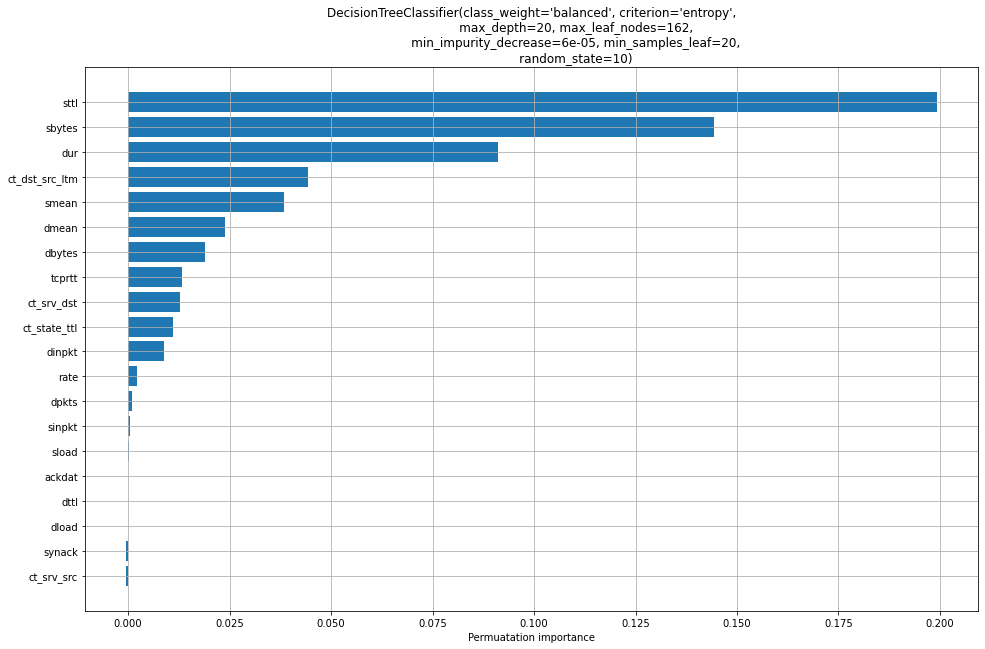

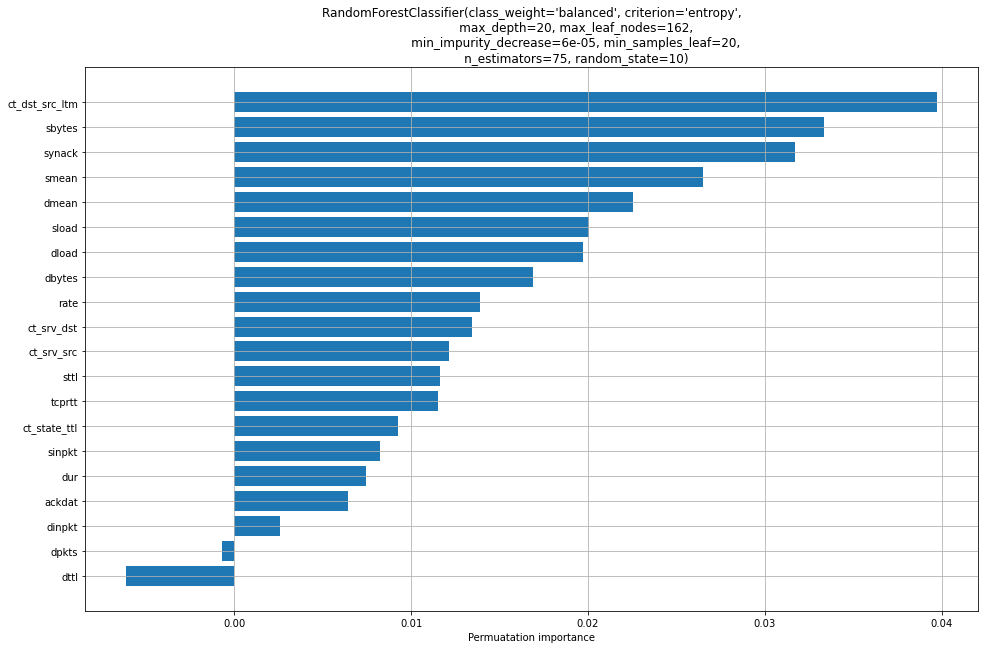

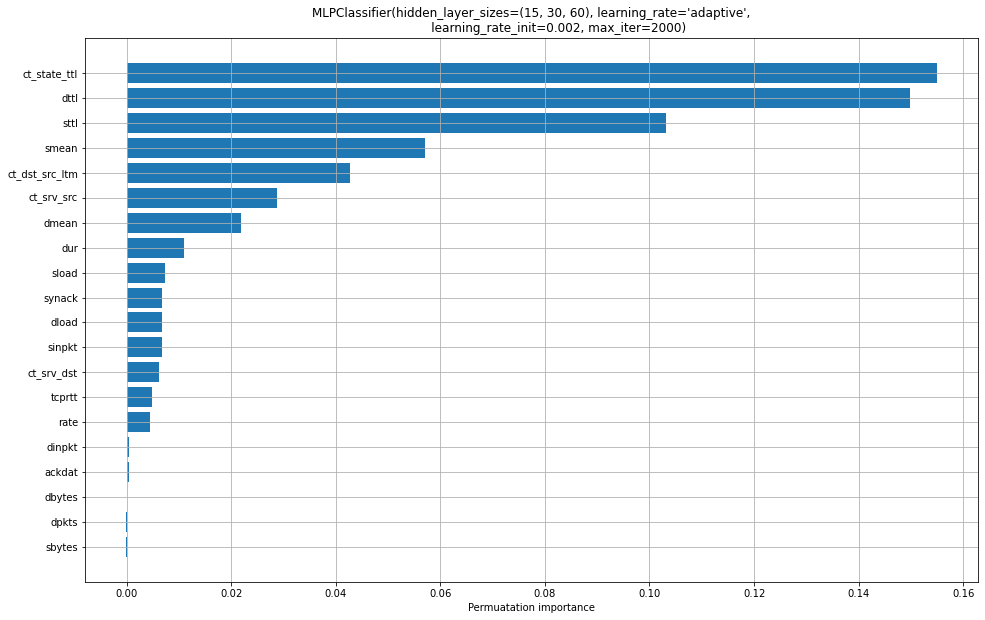

In [121]:
feature_importances = {}
for index, model in enumerate(models):
    features = np.array(chosen_features)
    importances = importances_list[index]
    importances_sorted = importances.argsort()
    plt.figure(figsize=(16,10))
    plt.grid()
    plt.title(str(model))
    plt.barh(features[importances_sorted], importances[importances_sorted])
    plt.xlabel('Permuatation importance')
    plt.show()
    